<a href="https://colab.research.google.com/github/adrian-lison/gnn-community-detection/blob/master/Notebooks/KarateCora.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



DGL at a Glance: Karate
=========================



Step 0: Problem description
---------------------------

We start with the well-known "Zachary's karate club" problem. The karate club
is a social network which captures 34 members and document pairwise links
between members who interact outside the club.  The club later divides into
two communities led by the instructor (node 0) and the club president (node
33). The network is visualized as follows with the color indicating the
community:

![](https://s3.us-east-2.amazonaws.com/dgl.ai/tutorial/img/karate-club.png)

   :align: center

The task is to predict which side (0 or 33) each member tends to join given
the social network itself.



Step 1: Creating a graph in DGL
-------------------------------
Creating the graph for Zachary's karate club goes as follows:



In [0]:
import dgl

def build_karate_club_graph():
    g = dgl.DGLGraph()
    # add 34 nodes into the graph; nodes are labeled from 0~33
    g.add_nodes(34)
    # all 78 edges as a list of tuples
    edge_list = [(1, 0), (2, 0), (2, 1), (3, 0), (3, 1), (3, 2),
        (4, 0), (5, 0), (6, 0), (6, 4), (6, 5), (7, 0), (7, 1),
        (7, 2), (7, 3), (8, 0), (8, 2), (9, 2), (10, 0), (10, 4),
        (10, 5), (11, 0), (12, 0), (12, 3), (13, 0), (13, 1), (13, 2),
        (13, 3), (16, 5), (16, 6), (17, 0), (17, 1), (19, 0), (19, 1),
        (21, 0), (21, 1), (25, 23), (25, 24), (27, 2), (27, 23),
        (27, 24), (28, 2), (29, 23), (29, 26), (30, 1), (30, 8),
        (31, 0), (31, 24), (31, 25), (31, 28), (32, 2), (32, 8),
        (32, 14), (32, 15), (32, 18), (32, 20), (32, 22), (32, 23),
        (32, 29), (32, 30), (32, 31), (33, 8), (33, 9), (33, 13),
        (33, 14), (33, 15), (33, 18), (33, 19), (33, 20), (33, 22),
        (33, 23), (33, 26), (33, 27), (33, 28), (33, 29), (33, 30),
        (33, 31), (33, 32)]
    # add edges two lists of nodes: src and dst
    src, dst = tuple(zip(*edge_list))
    g.add_edges(src, dst)
    # edges are directional in DGL; make them bi-directional
    g.add_edges(dst, src)

    return g

We can print out the number of nodes and edges in our newly constructed graph:



In [0]:
G = build_karate_club_graph()
print('We have %d nodes.' % G.number_of_nodes())
print('We have %d edges.' % G.number_of_edges())

We have 34 nodes.
We have 156 edges.


We can also visualize the graph by converting it to a `networkx
<https://networkx.github.io/documentation/stable/>`_ graph:



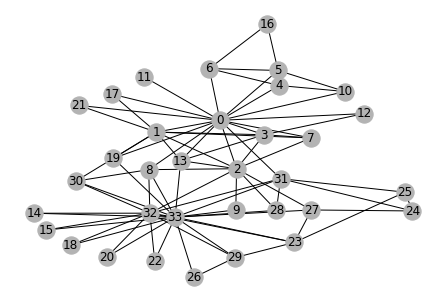

In [0]:
import networkx as nx
# Since the actual graph is undirected, we convert it for visualization
# purpose.
nx_G = G.to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)
nx.draw(nx_G, pos, with_labels=True, node_color=[[.7, .7, .7]])

Step 2: assign features to nodes or edges
--------------------------------------------
Graph neural networks associate features with nodes and edges for training.
For our classification example, we assign each node's an input feature as a one-hot vector:
node $v_i$'s feature vector is $[0,\ldots,1,\dots,0]$,
where the $i^{th}$ position is one.

In DGL, we can add features for all nodes at once, using a feature tensor that
batches node features along the first dimension. This code below adds the one-hot
feature for all nodes:



In [0]:
import torch

G.ndata['feat'] = torch.eye(34)

We can print out the node features to verify:



In [0]:
# print out node 2's input feature
print(G.nodes[2].data['feat'])

# print out node 10 and 11's input features
print(G.nodes[[10, 11]].data['feat'])

tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


Step 3: define a Graph Convolutional Network (GCN)
--------------------------------------------------
To perform node classification, we use the Graph Convolutional Network
(GCN) developed by `Kipf and Welling <https://arxiv.org/abs/1609.02907>`_. Here
we provide the simplest definition of a GCN framework, but we recommend the
reader to read the original paper for more details.

- At layer $l$, each node $v_i^l$ carries a feature vector $h_i^l$.
- Each layer of the GCN tries to aggregate the features from $u_i^{l}$ where
  $u_i$'s are neighborhood nodes to $v$ into the next layer representation at
  $v_i^{l+1}$. This is followed by an affine transformation with some
  non-linearity.

The above definition of GCN fits into a **message-passing** paradigm: each
node will update its own feature with information sent from neighboring
nodes. A graphical demonstration is displayed below.

![mailbox](https://s3.us-east-2.amazonaws.com/dgl.ai/tutorial/1_first/mailbox.png)

Now, we show that the GCN layer can be easily implemented in DGL.



In [0]:
import torch.nn as nn
import torch.nn.functional as F

# Define the message & reduce function
# NOTE: we ignore the GCN's normalization constant c_ij for this tutorial.
def gcn_message(edges):
    # The argument is a batch of edges.
    # This computes a (batch of) message called 'msg' using the source node's feature 'h'.
    return {'msg' : edges.src['h']}

def gcn_reduce(nodes):
    # The argument is a batch of nodes.
    # This computes the new 'h' features by summing received 'msg' in each node's mailbox.
    return {'h' : torch.sum(nodes.mailbox['msg'], dim=1)}

# Define the GCNLayer module
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, inputs):
        # g is the graph and the inputs is the input node features
        # first set the node features
        g.ndata['h'] = inputs
        # trigger message passing on all edges 
        g.send(g.edges(), gcn_message)
        # trigger aggregation at all nodes
        g.recv(g.nodes(), gcn_reduce)
        # get the result node features
        h = g.ndata.pop('h')
        # perform linear transformation
        return self.linear(h)

In general, the nodes send information computed via the *message functions*,
and aggregates incoming information with the *reduce functions*.

We then define a deeper GCN model that contains two GCN layers:



In [0]:
# Define a 2-layer GCN model
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.gcn1 = GCNLayer(in_feats, hidden_size)
        self.gcn2 = GCNLayer(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.gcn1(g, inputs)
        h = torch.relu(h)
        h = self.gcn2(g, h)
        return h
# The first layer transforms input features of size of 34 to a hidden size of 5.
# The second layer transforms the hidden layer and produces output features of
# size 2, corresponding to the two groups of the karate club.
net = GCN(34, 5, 3)

Step 4: data preparation and initialization
-------------------------------------------

We use one-hot vectors to initialize the node features. Since this is a
semi-supervised setting, only the instructor (node 0) and the club president
(node 33) are assigned labels. The implementation is available as follow.



In [0]:
inputs = torch.eye(34)
labeled_nodes = torch.tensor([0, 33, 31])  # only the instructor and the president nodes are labeled
labels = torch.tensor([0, 1, 2])  # their labels are different

Step 5: train then visualize
----------------------------
The training loop is exactly the same as other PyTorch models.
We (1) create an optimizer, (2) feed the inputs to the model,
(3) calculate the loss and (4) use autograd to optimize the model.



In [0]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
all_logits = []
for epoch in range(200):
    logits = net(G, inputs)
    # we save the logits for visualization later
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    # we only compute loss for labeled nodes
    loss = F.nll_loss(logp[labeled_nodes], labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

Epoch 0 | Loss: 1.8303
Epoch 1 | Loss: 1.4867
Epoch 2 | Loss: 1.2343
Epoch 3 | Loss: 1.0529
Epoch 4 | Loss: 0.9087
Epoch 5 | Loss: 0.8138
Epoch 6 | Loss: 0.7445
Epoch 7 | Loss: 0.6899
Epoch 8 | Loss: 0.6386
Epoch 9 | Loss: 0.5871
Epoch 10 | Loss: 0.5311
Epoch 11 | Loss: 0.4697
Epoch 12 | Loss: 0.4059
Epoch 13 | Loss: 0.3415
Epoch 14 | Loss: 0.2782
Epoch 15 | Loss: 0.2223
Epoch 16 | Loss: 0.1757
Epoch 17 | Loss: 0.1380
Epoch 18 | Loss: 0.1082
Epoch 19 | Loss: 0.0857
Epoch 20 | Loss: 0.0683
Epoch 21 | Loss: 0.0547
Epoch 22 | Loss: 0.0440
Epoch 23 | Loss: 0.0354
Epoch 24 | Loss: 0.0284
Epoch 25 | Loss: 0.0228
Epoch 26 | Loss: 0.0183
Epoch 27 | Loss: 0.0147
Epoch 28 | Loss: 0.0119
Epoch 29 | Loss: 0.0097
Epoch 30 | Loss: 0.0080
Epoch 31 | Loss: 0.0067
Epoch 32 | Loss: 0.0056
Epoch 33 | Loss: 0.0048
Epoch 34 | Loss: 0.0041
Epoch 35 | Loss: 0.0036
Epoch 36 | Loss: 0.0032
Epoch 37 | Loss: 0.0028
Epoch 38 | Loss: 0.0025
Epoch 39 | Loss: 0.0023
Epoch 40 | Loss: 0.0021
Epoch 41 | Loss: 0.0019
Ep

In [0]:
all_logits[89]

tensor([[ 6.9960, -0.4494, -8.9905],
        [ 4.1057,  0.0245, -4.1233],
        [ 1.2664,  2.0262,  2.1994],
        [ 2.9384, -0.3879, -1.8049],
        [ 1.6144, -0.6751,  0.4439],
        [ 1.7416, -0.6781,  0.5128],
        [ 1.7895, -0.6862,  0.4594],
        [ 2.2427, -0.6469, -0.2543],
        [-0.1409,  2.5661,  6.3719],
        [ 0.0789,  1.0112,  2.7378],
        [ 1.6623, -0.6832,  0.3905],
        [ 0.5735, -0.3297,  1.2680],
        [ 1.2119, -0.5484,  0.7744],
        [ 1.4208,  0.6673,  3.5892],
        [-1.3315,  1.9959,  6.6211],
        [-1.3315,  1.9959,  6.6211],
        [ 1.4038, -0.8431, -0.9581],
        [ 0.8490, -0.5040,  1.2994],
        [-1.3315,  1.9959,  6.6211],
        [ 0.0271,  0.8103,  5.1429],
        [-1.3315,  1.9959,  6.6211],
        [ 0.8490, -0.5040,  1.2994],
        [-1.3315,  1.9959,  6.6211],
        [-2.3477,  3.7715,  8.6576],
        [-0.3563,  1.2326,  1.1263],
        [-0.1256,  1.2895,  0.3550],
        [-1.0318,  1.6929,  4.0270],
 

In [0]:
#epoch #node
all_logits[25][33].numpy()

array([0.7694855, 4.5454836, 0.5032537], dtype=float32)

In [0]:
all_logits[25][33].numpy().argmax()

1

In [0]:
all_logits[25][33].numpy()[0:2]

array([0.7694855, 4.5454836], dtype=float32)

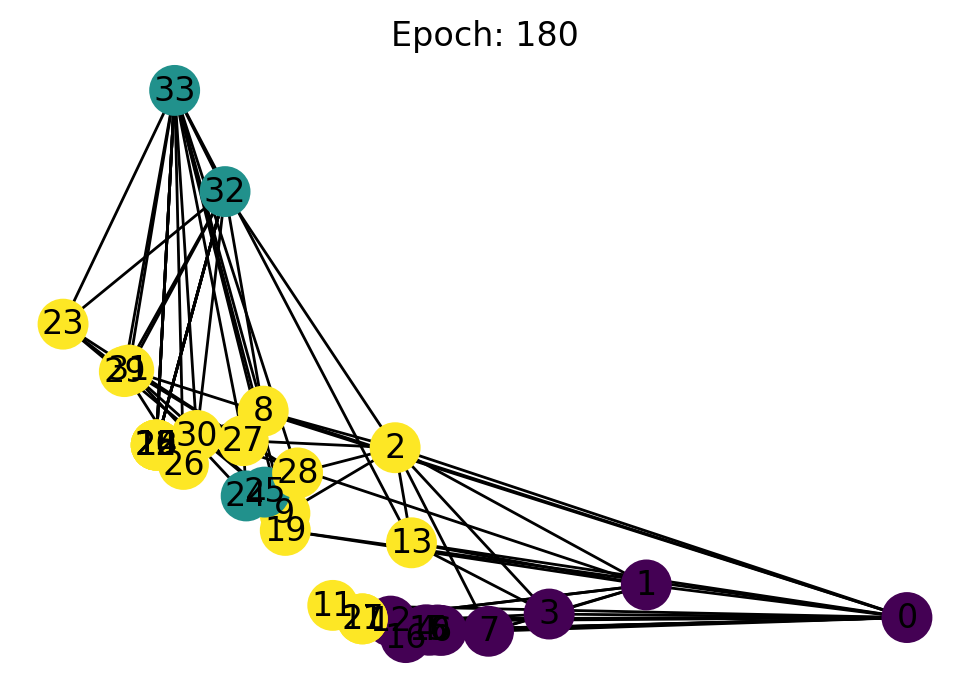

In [0]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt

def draw(i):
    cls1color = '#00FFFF'
    cls2color = '#FF00FF'
    pos = {}
    pos2d = {}
    colors = []
    for v in range(34):
        pos[v] = all_logits[i][v].numpy()
        cls = pos[v].argmax()
        pos2d[v] =  all_logits[i][v].numpy()[0:2]
        colors.append(cls)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw_networkx(nx_G.to_undirected(), pos2d, node_color=colors,
            with_labels=True, node_size=300, ax=ax)

fig = plt.figure(dpi=200)
fig.clf()
ax = fig.subplots()
draw(180)  # draw the prediction of the first epoch
#plt.close()

In [0]:
#Why this result

The following animation shows how the model correctly predicts the community
after a series of training epochs.



In [0]:
ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=50)
ani = ani.to_html5_video()

In [0]:
from IPython.display import HTML
HTML(ani)

In [0]:
%matplotlib inline
!pip install dgl

     |████████████████████████████████| 2.3MB 9.4MB/s 


# Karate Cora


In [0]:
%matplotlib inline
!pip install dgl

     |████████████████████████████████| 2.4MB 5.1MB/s 


In [0]:
from dgl.data import citation_graph as citegrh
import dgl
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph
import time
import numpy as np

In [0]:
#Loading CORA
data = citegrh.load_cora()
features = th.FloatTensor(data.features)
labelsCORA = th.LongTensor(data.labels)
mask = th.ByteTensor(data.train_mask)
g = data.graph
# removing doesnt work
#g.remove_edges_from(g.selfloop_edges())
g = DGLGraph(g)
g.add_edges(g.nodes(), g.nodes())

Extracting file to /root/.dgl/cora


In [0]:
G = g
print('We have %d nodes.' % G.number_of_nodes())
print('We have %d edges.' % G.number_of_edges())

We have 2708 nodes.
We have 13264 edges.


In [0]:
import torch
#number of nodes
G.ndata['feat'] = torch.eye(2708)

In [0]:
# print out node 2's input feature
print(G.nodes[2].data['feat'])

tensor([[0., 0., 1.,  ..., 0., 0., 0.]])


In [0]:
import torch.nn as nn
import torch.nn.functional as F

# Define the message & reduce function
# NOTE: we ignore the GCN's normalization constant c_ij for this tutorial.
def gcn_message(edges):
    # The argument is a batch of edges.
    # This computes a (batch of) message called 'msg' using the source node's feature 'h'.
    return {'msg' : edges.src['h']}

def gcn_reduce(nodes):
    # The argument is a batch of nodes.
    # This computes the new 'h' features by summing received 'msg' in each node's mailbox.
    return {'h' : torch.sum(nodes.mailbox['msg'], dim=1)}

# Define the GCNLayer module
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, inputs):
        # g is the graph and the inputs is the input node features
        # first set the node features
        g.ndata['h'] = inputs
        # trigger message passing on all edges 
        g.send(g.edges(), gcn_message)
        # trigger aggregation at all nodes
        g.recv(g.nodes(), gcn_reduce)
        # get the result node features
        h = g.ndata.pop('h')
        # perform linear transformation
        return self.linear(h)

In [0]:
# Define a 2-layer GCN model
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.gcn1 = GCNLayer(in_feats, hidden_size)
        self.gcn2 = GCNLayer(hidden_size, num_classes)

    def forward(self, g, inputs):
        h = self.gcn1(g, inputs)
        h = torch.relu(h)
        h = self.gcn2(g, h)
        return h
# The first layer transforms input features of size of 34 to a hidden size of 5.
# The second layer transforms the hidden layer and produces output features of
# size 2, corresponding to the two groups of the karate club.
net = GCN(2708, 21, 7)

In [0]:
import random as rng

def get_label(x):
  return(int(labelsCORA[x]))

#Percentage of nodes known for training
percentage_open_nodes = 0.02
graph_node_size = int(G.number_of_nodes())
open_nodes = rng.sample(range(0,graph_node_size),int(graph_node_size*percentage_open_nodes))
open_nodes_labels = list(map(get_label,open_nodes))
len(open_nodes)

54

In [0]:
inputs = torch.eye(graph_node_size)
labeled_nodes = torch.tensor(open_nodes)  #
labels = torch.tensor(open_nodes_labels)  # 

In [0]:
#Helper to print accuracy
def output_accuracy(i,logits0):
  all_logits = logits0
  labels_final = []

  for v in range(graph_node_size):
    calculated_label = all_logits[i][v].numpy().argmax()
    labels_final.append(calculated_label)
  n_correct = 0
  n_correct_random = 0
  for v in range(graph_node_size):
    if (labels_final[v] == int(labelsCORA[v])):
      n_correct +=1
    if (int(rng.randrange(0,6)) == int(labelsCORA[v])):
      n_correct_random +=1
  print("Accuracy with " + str(int(percentage_open_nodes*100)) + "% labeld nodes: " + str(n_correct/graph_node_size) + " including " + str(int(graph_node_size*percentage_open_nodes)) + " prelabeld nodes. Excluding: " + str((n_correct-len(open_nodes))/(graph_node_size-len(open_nodes))) )

In [0]:
net = GCN(2708, 21, 7)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
all_logits = []
for epoch in range(50):
    logits = net(G, inputs)
    # we save the logits for visualization later
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    # we only compute loss for labeled nodes
    loss = F.nll_loss(logp[labeled_nodes], labels)
    val_loss = F.nll_loss(logp.detach(), labelsCORA)
    #val_loss=torch.tensor(42)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print('Epoch %d | Loss: %.4f | Total: %.4f' % (epoch, loss.item(), val_loss.item()))
    output_accuracy(epoch,all_logits)

Epoch 0 | Loss: 1.9442 | Total: 1.9397
Accuracy with 2% labeld nodes: 0.15103397341211225 including 54 prelabeld nodes. Excluding: 0.13376036171816127
Epoch 1 | Loss: 1.6460 | Total: 1.7872
Accuracy with 2% labeld nodes: 0.3430576070901034 including 54 prelabeld nodes. Excluding: 0.3296910324039186
Epoch 2 | Loss: 1.3463 | Total: 1.6392
Accuracy with 2% labeld nodes: 0.4623338257016248 including 54 prelabeld nodes. Excluding: 0.45139412207987945
Epoch 3 | Loss: 1.1084 | Total: 1.5486
Accuracy with 2% labeld nodes: 0.49704579025110784 including 54 prelabeld nodes. Excluding: 0.48681235870384326
Epoch 4 | Loss: 0.9259 | Total: 1.5068
Accuracy with 2% labeld nodes: 0.516248153618907 including 54 prelabeld nodes. Excluding: 0.506405425772419
Epoch 5 | Loss: 0.7810 | Total: 1.4945
Accuracy with 2% labeld nodes: 0.5398818316100443 including 54 prelabeld nodes. Excluding: 0.5305199698568199
Epoch 6 | Loss: 0.6578 | Total: 1.4977
Accuracy with 2% labeld nodes: 0.551698670605613 including 54 pr

In [0]:
#Access to calculated logits per epoch and node
#epoch #node
all_logits[4][2000].numpy()
all_logits[4][2500].numpy().argmax()
all_logits[4][33]

tensor([-0.2086, -0.2048,  0.4877, -0.0416, -0.2286, -0.3503,  0.0758])

In [0]:
#Create PCA feature transformation based on last epoch
final = 49
features_final = {}

for v in range(graph_node_size):
  features_final[v] = all_logits[final][v].numpy()

In [0]:
#Show final features of first node
import pandas as pd
df = pd.DataFrame.from_dict(features_final,orient='index')
df.head(1)

,0,1,2,3,4,5,6
0,-5.667466,-1.054757,3.05605,0.079027,-0.869008,-2.964351,-1.68857


In [0]:
# Scaling before PCA
from sklearn.preprocessing import StandardScaler 
sc = StandardScaler() 

X_train = sc.fit_transform(df) 

# Applying PCA function on training 
# and testing set of X component 
from sklearn.decomposition import PCA 
  
pca = PCA(n_components = 2) 
  
X_train = pca.fit_transform(X_train) 
#X_test = pca.transform(X_test) 
  
explained_variance = pca.explained_variance_ratio_ 
explained_variance

array([0.47364775, 0.27762036])

In [0]:
#Apply to the previously calculated model
def tranform_with_pca(logits):
  X_test = sc.transform(pd.DataFrame(logits).transpose()) 
  X_test = pca.transform(X_test) 
  return(X_test[0])

In [0]:
#Method to normalize a dataframe
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [0]:
#Postions per epoch for PCA
pos_epochs = {}
for x in range(final+1):
  pos2d = {}
  for v in range(graph_node_size):
    pos2d[v] =  tranform_with_pca(all_logits[x][v].numpy())
  df = (pd.DataFrame(pos2d)).transpose()
  df_normalized = normalize(df)
  #Apply 0.35 Root to make outliers smaller
  df_normalized = df_normalized.applymap(lambda x : x**0.35)
  pos_epochs[x] = df_normalized

In [0]:
#You could also use this for transforming and reducing outliers
import math
def fake_log(x):
  base = 1.5
  if (x == 0):
    return(0)
  if (x < 0):
    return(math.log((x*-1),base)*-1)
  else:
    return(math.log(x,base))

In [0]:
#Alternative: Create positions with tsne for ONE epoch
from sklearn.manifold import TSNE

pos_epochs[final] = pd.DataFrame(TSNE(n_components=2,n_iter=250).fit_transform(all_logits[final].numpy()))

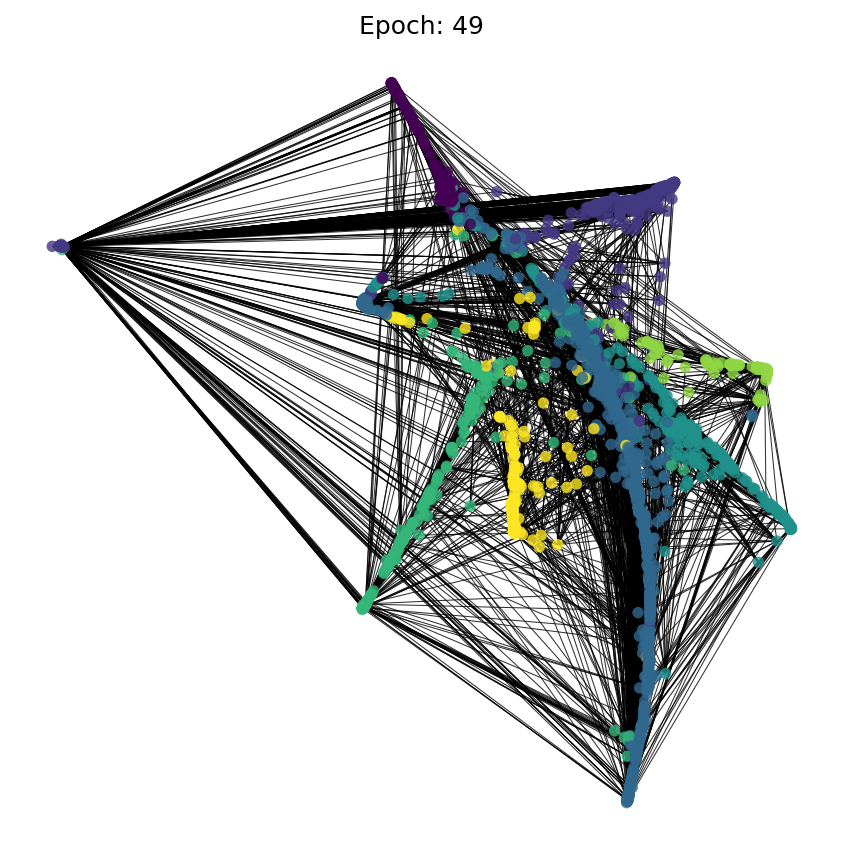

In [0]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import networkx as nx
nx_G = G.to_networkx().to_undirected()

def draw(i):
    #cls1color = '#00FFFF'
    #cls2color = '#FF00FF'
    pos = {}
    pos2d = {}
    colors = []
    for v in range(graph_node_size):
        pos[v] = all_logits[i][v].numpy()
        cls = pos[v].argmax()
        #Toggle next rows
        #pos2d[v] =  tranform_with_pca(pos[v])
        #pos2d[v] = df_normalized.loc[[v]].values[0]
        pos2d[v] = pos_epochs[i].loc[[v]].values[0]
        colors.append(cls)
    ax.cla()
    ax.axis('off')
    ax.set_title('Epoch: %d' % i)
    nx.draw_networkx(nx_G.to_undirected(), pos=pos2d , node_color=colors,
            with_labels=False, node_size=30, ax=ax, width=0.5, alpha=0.8, linewidths=0)

fig = plt.figure(dpi=150,figsize=(7, 7))
fig.clf()
ax = fig.subplots()
draw(49)  # draw the prediction of the first epoch
#plt.close()

In [0]:
#ani = animation.FuncAnimation(fig, draw, frames=len(all_logits), interval=100)
ani = animation.FuncAnimation(fig, draw, frames=final+1, interval=100)
ani = ani.to_html5_video()
from IPython.display import HTML
HTML(ani)